In [20]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb

Wczytanie danych z pliku do obiektu Data Frame.

In [2]:
df = pd.read_csv('./data/ames2000_NAfix.csv')
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,9,2006,New,Partial,342643


In [3]:
df.shape

(2000, 80)

Ponieważ domyślnie obiekt Data Frame pokazuje tylko niektóre początkowe i końcowe kolumny, zwiększam parametry max_colums, max_rows co pozwoli przegląd pełnego zakresu danych, także po transpozycji.

In [4]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

In [5]:
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0
Year.Remod.Add,2000.0,1984.0135,20.881771,1950.0,1965.00,1993.0,2004.00,2010.0
X1st.Flr.SF,2000.0,1158.7155,379.701015,407.0,877.75,1088.0,1391.25,4692.0
X2nd.Flr.SF,2000.0,334.3805,427.519973,0.0,0.00,0.0,703.25,2065.0
Low.Qual.Fin.SF,2000.0,4.3790,42.555738,0.0,0.00,0.0,0.00,697.0
Gr.Liv.Area,2000.0,1497.4750,498.561719,407.0,1126.75,1447.5,1734.00,5642.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

Istnieje 9 kolumn zawierających wartości null. Braki dotyczą cech piwnicy i garażu oraz forniru murarskiego. W kolejnym kroku sprawdzane są unikalne wartości dla tych kolumn.

In [8]:
contains_nulls = ['Mas.Vnr.Type','Bsmt.Qual','Bsmt.Cond','Bsmt.Exposure',
                  'BsmtFin.Type.1','BsmtFin.Type.2','Garage.Finish','Garage.Qual','Garage.Cond']

for item in contains_nulls:
    print(item, ':', df[item].unique())

Mas.Vnr.Type : ['Stone' 'None' 'BrkFace' nan 'BrkCmn' 'CBlock']
Bsmt.Qual : ['Gd' 'TA' 'None' 'Ex' 'Fa' nan 'Po']
Bsmt.Cond : ['TA' 'None' 'Gd' 'Fa' 'Ex' nan 'Po']
Bsmt.Exposure : ['Av' 'No' 'None' 'Gd' 'Mn' nan]
BsmtFin.Type.1 : ['ALQ' 'GLQ' 'None' 'Unf' 'LwQ' 'Rec' 'BLQ' nan]
BsmtFin.Type.2 : ['Unf' 'Rec' 'None' 'GLQ' 'ALQ' 'LwQ' 'BLQ' nan]
Garage.Finish : ['RFn' 'Fin' 'Unf' 'None' nan]
Garage.Qual : ['TA' 'None' 'Fa' 'Gd' nan 'Po' 'Ex']
Garage.Cond : ['TA' 'None' 'Gd' 'Fa' 'Po' nan 'Ex']


Po analizie list wartości dla poszczególnych pól przyjmuję założenie, że brak informacji oznaczać będzie brak cechy. Dlatego brakujące wartości zostaną uzupełnione wartością None.

In [9]:
for item in contains_nulls:
    df[item].fillna('None', inplace=True)

Ponowne sprawdzam, czy modyfikowane kolumny zawierają wartości różne od null.

In [10]:
df[contains_nulls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
Mas.Vnr.Type      2000 non-null object
Bsmt.Qual         2000 non-null object
Bsmt.Cond         2000 non-null object
Bsmt.Exposure     2000 non-null object
BsmtFin.Type.1    2000 non-null object
BsmtFin.Type.2    2000 non-null object
Garage.Finish     2000 non-null object
Garage.Qual       2000 non-null object
Garage.Cond       2000 non-null object
dtypes: object(9)
memory usage: 140.7+ KB


Następnie usuwam kolumny mogące nieść 'information leaks', tj. kolumny:
    'Misc.Val', 'Mo.Sold', 'Yr.Sold', 'Sale.Type', 'Sale.Condition', 'SalePrice'

W szczególności 'SaleProce' jest zmienną objaśnianą.

Przed usunięciem tworzona jest kopia zapasowa obiektu DataFrame.

In [11]:
df_copy = df.copy()
df_copy.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


In [12]:
# NARAZIE ZOSTAJĄ!!
# df.drop(labels=['Misc.Val', 'Mo.Sold', 'Yr.Sold', 'Sale.Type', 'Sale.Condition', 'SalePrice'], axis=1, inplace=True)
# df.head(10)

Sprawdzenie liczby unikalnych wartości dla każdej z kolumn.

In [13]:
types = df.dtypes
nunique = df.nunique()
df_info = pd.DataFrame(pd.concat([types, nunique], axis =1))
df_info = df_info.rename(columns={0:'Type', 1:'Num_unique'}).sort_values(by='Num_unique', ascending=False)
df_info

,Type,Num_unique
Lot.Area,int64,1424
Gr.Liv.Area,int64,1051
Bsmt.Unf.SF,object,928
X1st.Flr.SF,int64,902
Total.Bsmt.SF,object,871
BsmtFin.SF.1,object,817
SalePrice,int64,812
Garage.Area,object,531
X2nd.Flr.SF,int64,500
Mas.Vnr.Area,object,363


Sprawdzenie czy istnieją kolumny posiadające tylko jedną unikalną wartość.

In [14]:
nunique_series = df.nunique() == 1
nunique_series.where(nunique_series == True).dropna()

Utilities    1.0
dtype: float64

Kolumnę można również wyrzucić z obiektu DataFrame, nie ma wpływu na dalszą analizę.

In [15]:
df.drop(labels=['Utilities'], axis=1, inplace=True)
df.head(10)

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643
5,20,RL,50,4280,Pave,None,IR1,Lvl,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,4,9,1946,2001,Gable,CompShg,MetalSd,MetalSd,None,0,TA,Gd,CBlock,Fa,TA,No,Unf,0,Unf,0,560,560,GasA,Ex,Y,FuseA,704,0,0,704,0,1,1,0,2,1,Fa,4,Typ,0,None,CarPort,1946,Unf,1,220,TA,TA,Y,0,0,24,0,0,0,None,None,None,0,9,2009,WD,Normal,88750
6,20,RL,155,20064,Pave,None,IR1,Low,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,8,6,1976,1976,Shed,WdShngl,Wd Sdng,Wd Sdng,None,0,Gd,TA,CBlock,Gd,Gd,Gd,LwQ,51,GLQ,915,0,966,GasA,Ex,Y,SBrkr,1743,0,0,1743,2,0,0,1,0,1,Gd,5,Typ,2,Fa,Attchd,1976,Fin,2,529,TA,TA,Y,646,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,279000
7,20,RM,60,7200,Pave,Grvl,Reg,Lvl,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,4,5,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,576,576,GasA,Ex,Y,SBrkr,864,0,0,864,0,0,1,0,2,1,TA,5,Typ,0,None,Detchd,1952,RFn,1,528,TA,TA,Y,0,0,0,0,115,0,None,None,None,0,8,2006,COD,Normal,105000
8,20,RL,70,9100,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,244,Gd,TA,PConc,Gd,TA,Av,GLQ,1400,Unf,0,125,1525,GasA,Ex,Y,SBrkr,1525,0,0,1525,1,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2000,RFn,2,541,TA,TA,Y,219,36,0,0,0,0,None,None,None,0,9,2006,WD,Normal,235000
9,70,C (all),None,6449,Pave,None,IR1,Lvl,Inside,Gtl,SWISU,Norm,Norm,1Fam,2Story,4,1,1907,1950,Gambrel,CompShg,Wd Sdng,Stucco,None,0,TA,TA,CBlock,TA,TA,No,Rec,73,Unf,0,634,707,GasW,TA,N,SBrkr,942,942,0,1884,0,0,1,1,4,1,TA,7,Typ,0,None,None,

Sprawdzam korelacje między danymi typu numerycznego. W tym celu rysuję heatmapę.

Dla przejrzystości analizy rozdzielam zmienne numeryczne od tekstowych. 

In [17]:
df_numeric = df_info[df_info['Type'] == 'int64']
df_text = df_info[df_info['Type'] == 'object']
print(f'Amount of numeric data: {len(df_numeric)}, Amount of text data: {len(df_text)}')

numeric = df_numeric.index
text = df_text.index
print(f'Numeric columns: {numeric}')
print(f'Text columns: {text}')

Amount of numeric data: 26, Amount of text data: 54
Numeric columns: Index(['Lot.Area', 'Gr.Liv.Area', 'X1st.Flr.SF', 'SalePrice', 'X2nd.Flr.SF',
       'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'Year.Built',
       'Screen.Porch', 'Year.Remod.Add', 'Misc.Val', 'Low.Qual.Fin.SF',
       'X3Ssn.Porch', 'MS.SubClass', 'Mo.Sold', 'Pool.Area', 'TotRms.AbvGrd',
       'Overall.Qual', 'Overall.Cond', 'Bedroom.AbvGr', 'Fireplaces',
       'Full.Bath', 'Yr.Sold', 'Kitchen.AbvGr', 'Half.Bath'],
      dtype='object')
Text columns: Index(['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area',
       'Mas.Vnr.Area', 'BsmtFin.SF.2', 'Lot.Frontage', 'Garage.Yr.Blt',
       'Neighborhood', 'Exterior.2nd', 'Exterior.1st', 'Sale.Type',
       'Condition.1', 'House.Style', 'Functional', 'Garage.Type',
       'Garage.Cars', 'MS.Zoning', 'Condition.2', 'Roof.Matl',
       'BsmtFin.Type.2', 'BsmtFin.Type.1', 'Heating', 'Roof.Style',
       'Garage.Cond', 'Bsmt.Cond', 'Bsmt.Qual', 'Fireplac

Analizie w pierwszym kroku zostaną poddane zmienne numeryczne. Wśród nich znajduje się również 'SalesPrice'.

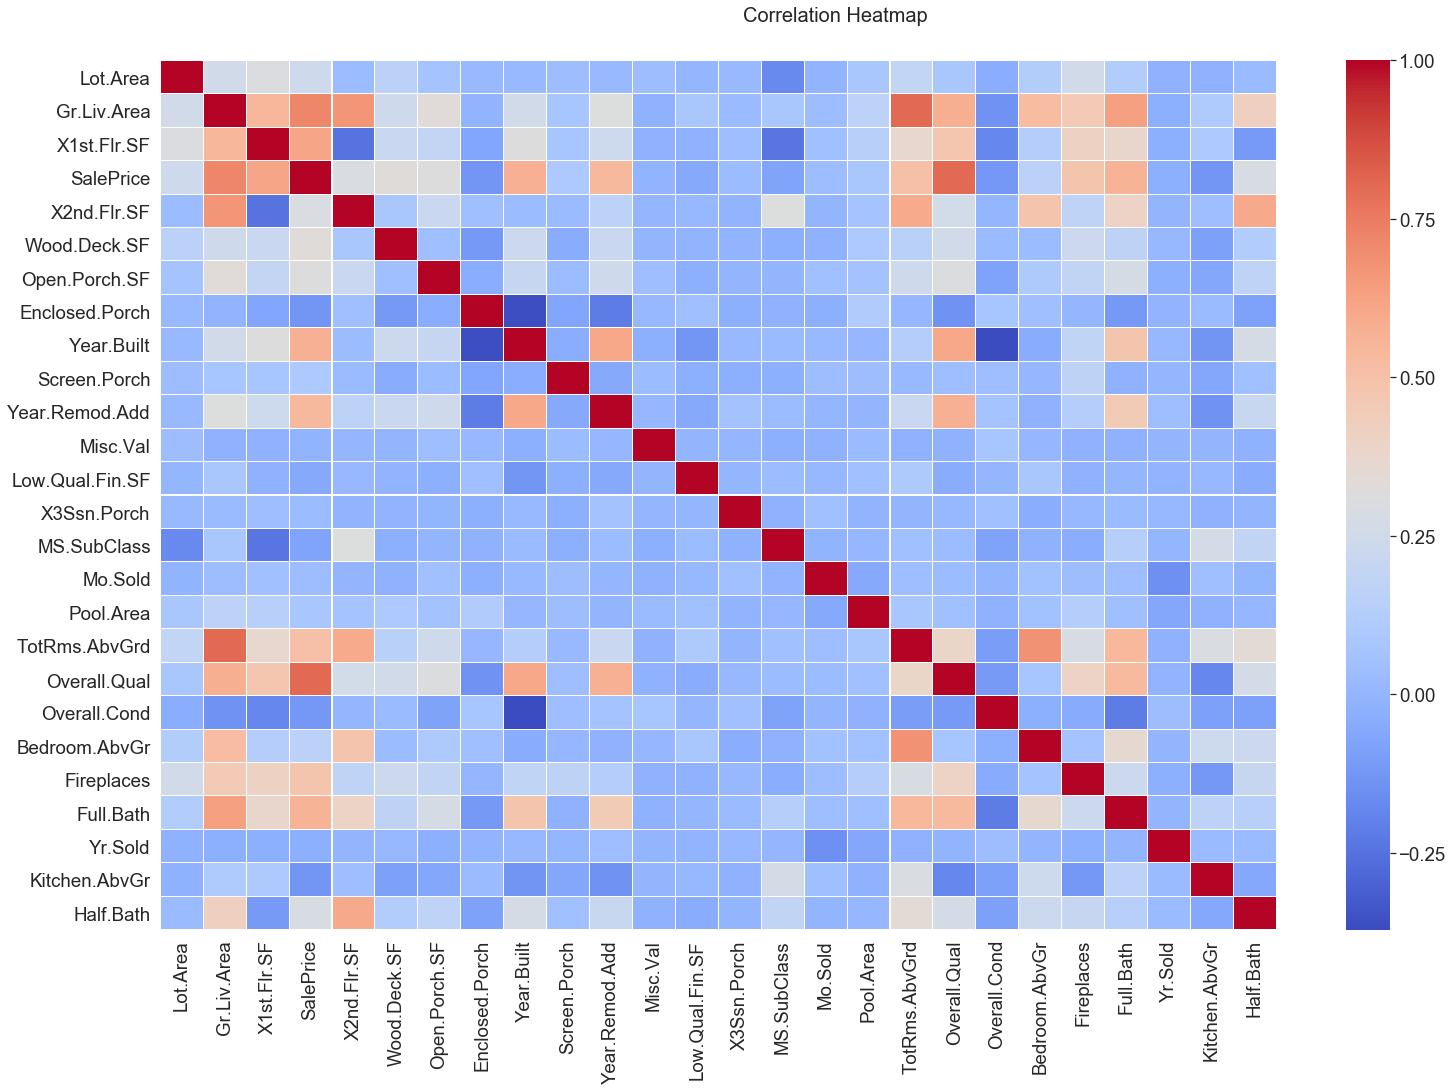

In [18]:
sns.set(style='darkgrid', font_scale=1.7)
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(df[numeric].corr(), annot=False, cmap="coolwarm",fmt='.2f',linewidths=.05 )
fig.subplots_adjust(top=0.93)
fig.suptitle('Correlation Heatmap', fontsize=20)
plt.show()

Istnieje korelacja zmiennej 'SalePrice' ze zmniennymi:
'Gr.Liv.Area', 'X1st.Flr.SF', 'Year.Built', 'Year.Remod.Add', 'TotRms.AbvGrd', 'Overall.Qual', 'Fireplaces', 'Full.Bath'.

Najsilniejsza korelacja ceny 'SalePrice' z 'Gr.Liv.Area', 'Overall.Qual'.

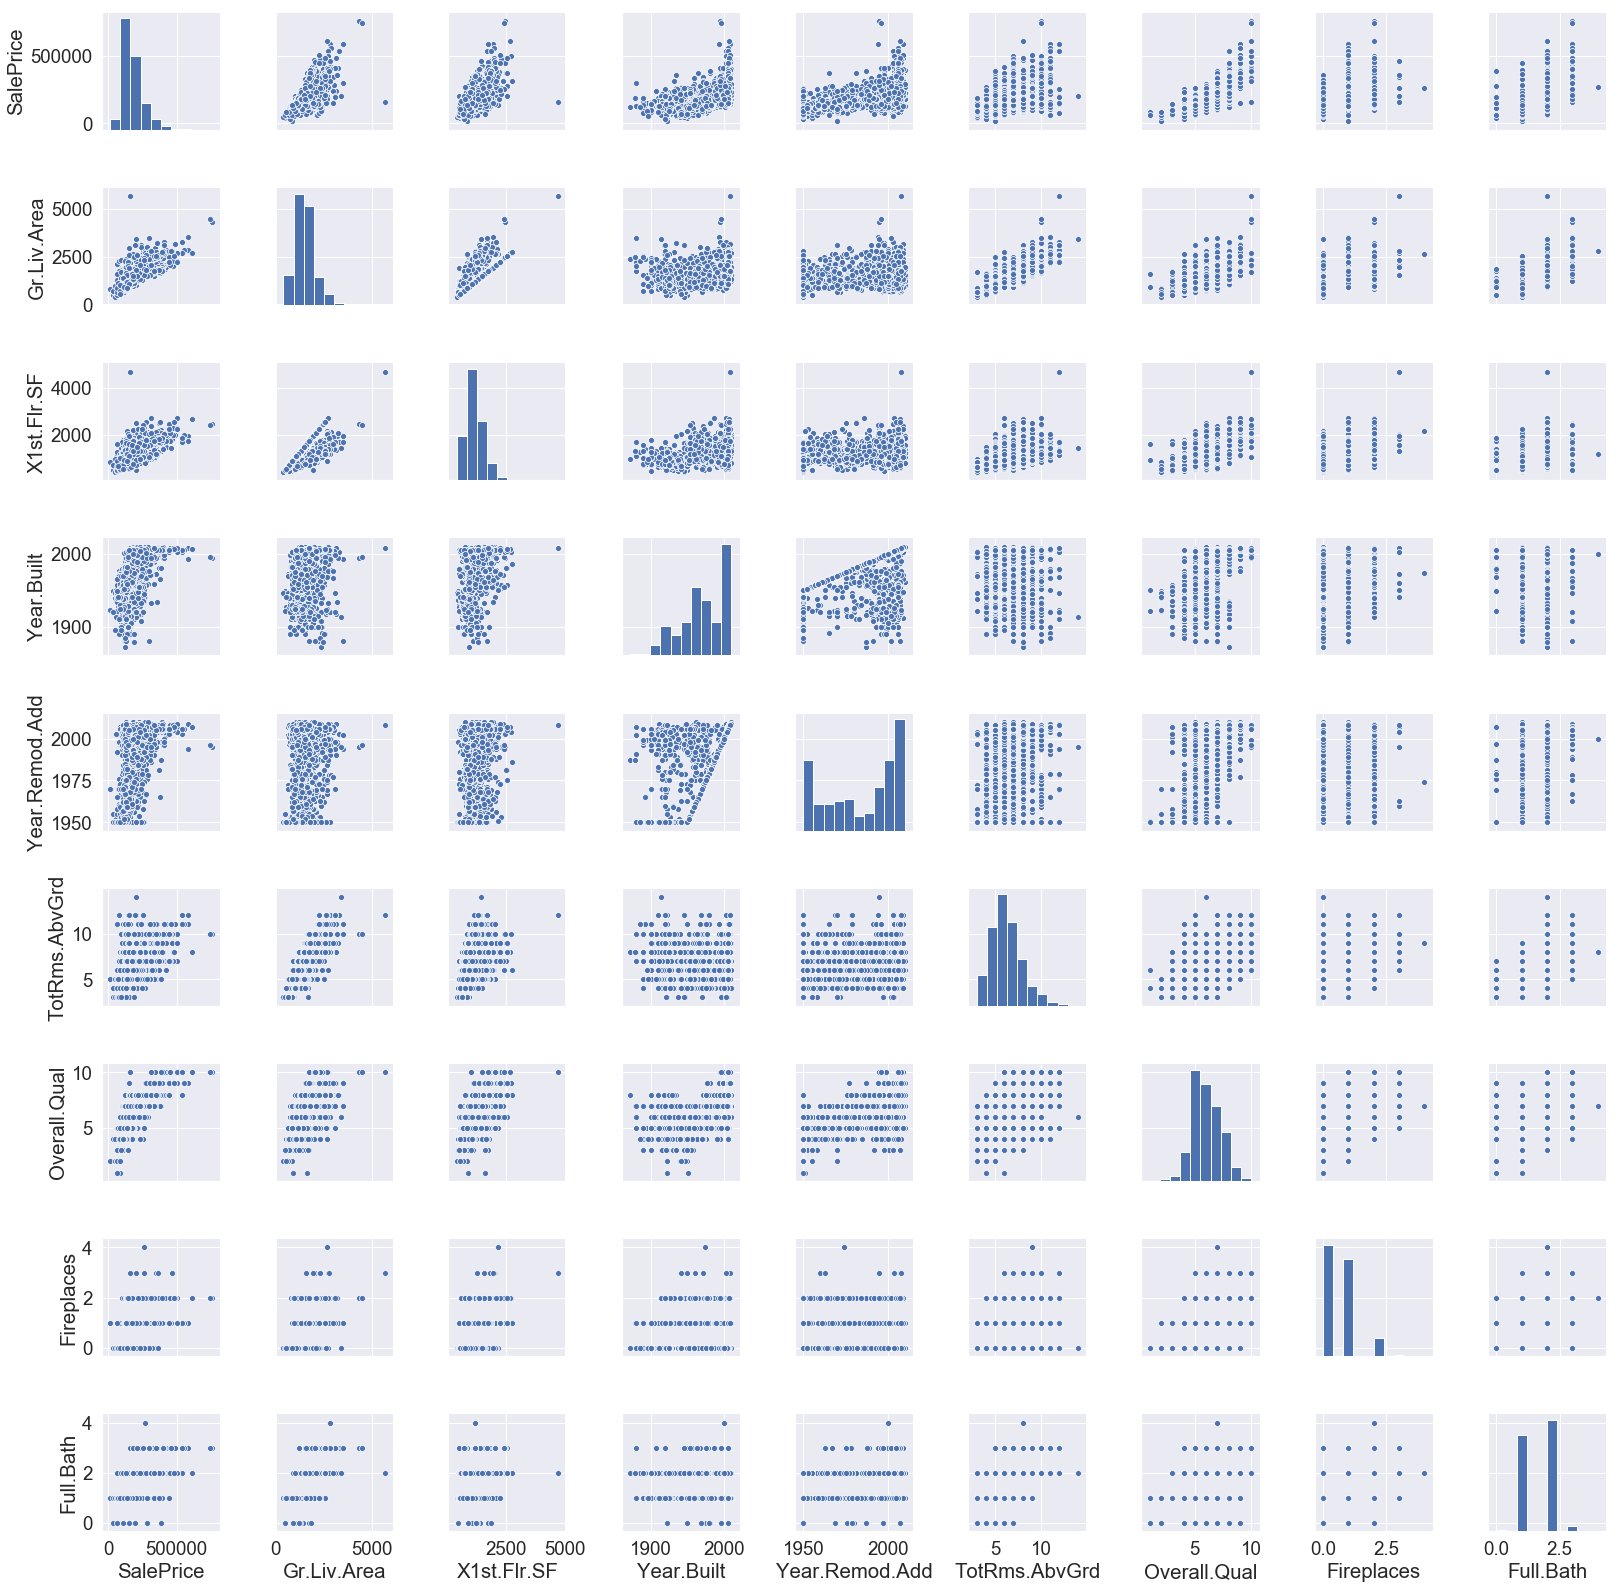

In [32]:
df1 = df[['SalePrice', 'Gr.Liv.Area', 'X1st.Flr.SF', 'Year.Built', 'Year.Remod.Add', 
                    'TotRms.AbvGrd', 'Overall.Qual', 'Fireplaces', 'Full.Bath']]


sns.pairplot(data=df1)
plt.show()